# Color quantization, yellow line detection, box along only yellow lines

This notebook is highly based on the code Matthew, Junjie and Carlos have wrotten with minor modifications done by me. Here I used the OpenCV libaray and put a fixed yellow BGR for predicting label.

In [1]:
# import libraries
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import cv2
from pathlib import Path

In [2]:
# define reshaped size
WIDTH = 512
HEIGHT = 512

In [3]:
# define a list with all file names
pl = Path("Parking Lot")
rd = Path("Road")

filenames = [str(file) for file in pl.iterdir()]
filenames = filenames + [str(file) for file in rd.iterdir()]

num_files = len(filenames)

In [4]:
# load in resized images
ims = [cv2.resize(cv2.imread(file),(WIDTH,HEIGHT)) for file in filenames]

In [5]:
# reshape the list
pixel_list = [im.reshape((-1, 3)) for im in ims]
pixels = np.concatenate(pixel_list, axis=0)

In [6]:
# apply clustering on all images
n_clusters=10

model = KMeans(n_clusters=n_clusters)
model.fit(pixels)

KMeans(n_clusters=10)

In [7]:
# define the yellow color and predict the label 
yellow = np.array([0, 200, 210 ])
yellow_label = model.predict(yellow.reshape((1, -1)))

In [8]:
# save all the clustered images and the resulting images after filtering 

for index in range(num_files):
    filename = filenames[index].split('/')[-1].split('.')[0]
    
    resized_img = pixels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)].reshape((HEIGHT, WIDTH, 3))
    output_name = "Output/Color_Quantization_2/Resized_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,resized_img)
    
    colors = model.cluster_centers_
    img_labels = model.labels_
    transformed_img = colors[(img_labels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)])].reshape((HEIGHT, WIDTH, 3))
    output_name = "Output/Color_Quantization_2/Transformed_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,transformed_img)

    mask = (img_labels[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)] == yellow_label).reshape((HEIGHT, WIDTH, 1))
    masked_image = ims[index]*mask
    output_name = "Output/Color_Quantization_2/Masked_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name,masked_image)

## Now let's take a look at these masked images and do analysis from there 

Our resized image has the shape: (512, 512, 3)


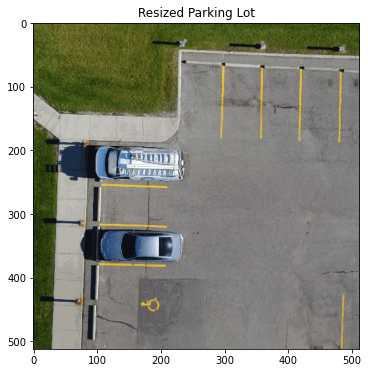

In [9]:
filen = "Lot1"
resizedfilename = "Output/Color_Quantization_2/Resized_"+filen+".jpg"
img_resized = cv2.imread(resizedfilename, 1)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.title('Resized Parking Lot');
print("Our resized image has the shape: {}".format(img_resized.shape))
plt.imshow(img_resized)
plt.show()

Our masked image has the shape: (512, 512, 3)


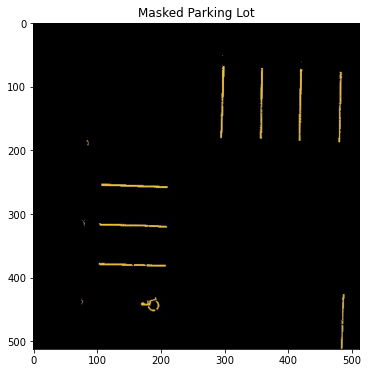

In [10]:
maskedfilename = "Output/Color_Quantization_2/Masked_"+filen+".jpg"
masked_img = cv2.imread(maskedfilename, 1)
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.title('Masked Parking Lot');
print("Our masked image has the shape: {}".format(masked_img.shape))
plt.imshow(masked_img)
plt.show()

In [11]:
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)

In [12]:
# parameters kernel size and sigma 
gblur = cv2.GaussianBlur(masked_img, (7,7),0)

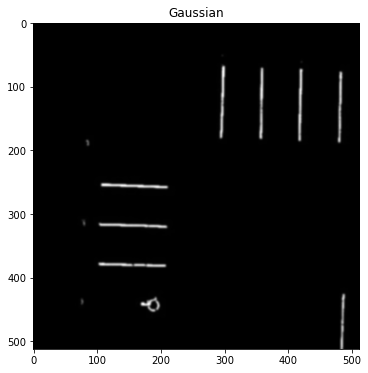

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(gblur, cmap = 'gray')
plt.title('Gaussian');
plt.show()

In [14]:
# two parameters need to play with
minval = 150
maxval = 280
canny_bF = cv2.Canny(gblur, minval, maxval)

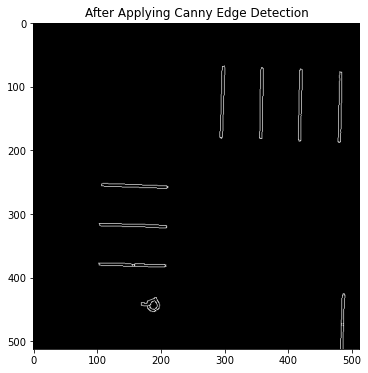

True

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(canny_bF, cmap = 'gray')
plt.title('After Applying Canny Edge Detection');
plt.show()
finaloutname = "Output/Color_Quantization_2/Edge_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
cv2.imwrite(finaloutname,canny_bF )

In [16]:
# three parameters need to play with
lines = cv2.HoughLinesP(canny_bF, 1, np.pi/180, threshold = 19, minLineLength = 10, maxLineGap = 10)

In [17]:
# draw the detected lines
for line in lines:
    x1, y1, x2, y2 = line[0]   
    im = cv2.line(img_resized, (x1,y1), (x2, y2), ( 255, 0, 0), 2)

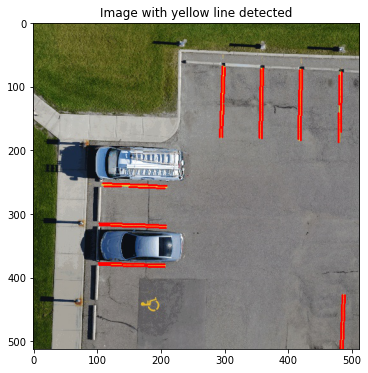

True

In [18]:
#img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(im)
plt.title('Image with yellow line detected');
plt.show()

# save the image with line detected and display it
finaloutname = "Output/Color_Quantization_2/Detected_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
cv2.imwrite(finaloutname, im)

What I found: 
* We increased the cluster number to be k = 10
* Canny Edge detection seems work better in grayscale images
* Parameters should be considered:
    * In Gaussain blur, need to select the size of kernel 
    * In Canny edge detection, need to select minimal value and maximal value for edge detection threshold
    * In Hough line detection, need to select threshold, minlinelength and maxlinegap
* Should adjust the parameters in Canny edge detection and Hough line detection according to the images. However, for the images we have, not a huge change among images. 
* Summary for the parameters, we have used here:
    * For all images, we have used kernal = 7, minlinelength = 10, maxlinegap = 10
    * For Lot1, Lot5, Lot6, Lot7, Lot8, Lot9, Lot10, Lot11, Road2, minval = 150, maxval = 280, threshold = 19
    * For Lot2, minval = 150, maxval = 280, threshold = 18
    * For Lot3, Lot4, Road1, minval = 150, maxval = 300, threshold = 15
    * For Road3, minval = 100, maxval = 200, threshold = 19
    * For Lot11, minval = 100, maxval = 200, threshold = 15

### This newly added part is from Carlos's code, which draw boxed around different objects based on Canny edge detection. If object comes along with different shapes, like line and wheelchair, then we will do a secondary clustering (k = 2) to only keep the long lines.

In [19]:
# load resized images 
img_resized = cv2.imread(resizedfilename, 1)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

In [20]:
# get contours based on edge detection results
_, contours,_ = cv2.findContours(canny_bF, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [21]:
boxes = []
bbdata = []

In [22]:
# saves contour stat and draw contours over objects
for i in range(len(contours)):
    rect = cv2.minAreaRect(contours[i])
    boxes.append(np.int0(cv2.boxPoints(rect)))
    _ ,_ ,w, h = cv2.boundingRect(contours[i])
    aspect_ratio = max(float(w)/h, float(h)/w)
    area = cv2.contourArea(contours[i])
    bbdata.append([aspect_ratio])
    im1 = cv2.drawContours(img_resized, boxes, -1, (255, 0, 0), 2)

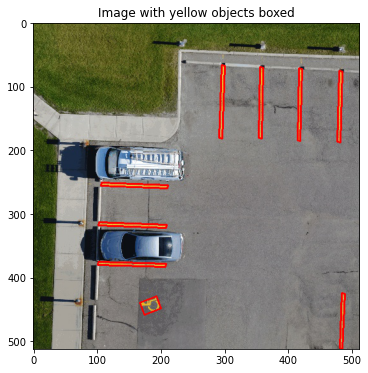

True

In [23]:
# display the object with boxes around
plt.figure(figsize=(6,6))
plt.imshow(im1)
plt.title('Image with yellow objects boxed');
plt.show()

finaloutname = "Output/Color_Quantization_2/Boxed_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
cv2.imwrite(finaloutname, im1)

In [24]:
# do a secondary object clustering if needed by checking the max width/height ratio
X = np.array(bbdata)
K = 2
model = KMeans(n_clusters = K)
model.fit(X)

KMeans(n_clusters=2)

In [25]:
properties_of_line = np.array([10]).reshape(1, -1)
label = model.predict(properties_of_line)

In [27]:
# filter out the not needed boxes 
boxes = [boxes[i] for i in np.where(model.labels_ == label)[0]]

In [28]:
img_resized = cv2.imread(resizedfilename, 1)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

In [29]:
# draw the countor boxes 
im2 = cv2.drawContours(img_resized, boxes, -1,(255, 0, 0), 2);

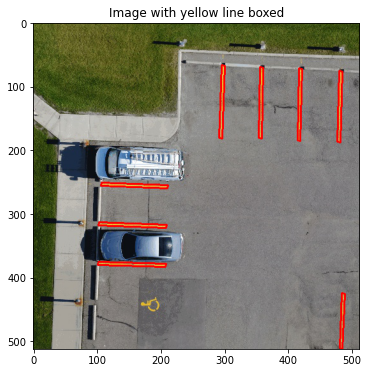

True

In [30]:
# display the results
plt.figure(figsize=(6,6))
plt.imshow(im2)
plt.title('Image with yellow line boxed');
plt.show()

finaloutname = "Output/Color_Quantization_2/Boxed_line_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
im2 = cv2.cvtColor(im2, cv2.COLOR_RGB2BGR)
cv2.imwrite(finaloutname, im2)

This 2-group clustering is really only designed for distinguishing long yellow lines with yellow wheelchair sign. For 
more complicated situation, better shape recognition method might needed. 